# Practicumopdracht 1

In deze opdracht wordt gekeken naar een pastaria: *La Cucina della Nonna*. Vanwege wettelijke beperkingen worden veel mensen weggestuurd voordat zij hier bediend kunnen worden. De pastaria wil deze situatie graag verbeteren en een groter aantal klanten serveren. Hiervoor zijn drie oplossingen bedacht, en in deze opdracht wordt gekeken, met behulp van een simulatie, welke oplossing het beste past bij de pastaria. De beste wordt gedefinieerd als de oplossing die het snelst wordt terugverdiend.

Hierbij zijn de volgende aannames gemaakt:
- Klanten komen altijd alleen
- Er is geen sprakte van balking of reneging (= Ze gaan niet-niet in de rij staan of verlaten de wachtrij)
- Na sluitingstijd worden de klanten die al bij de pastaria in de wachtrij staan nog geholpen

In [2]:
# importeren packages
import salabim as sim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import statsmodels.stats.weightstats
import random

### Huidige situatie

Hieronder wordt de huidige situatie van de pastaria gesimuleerd. Om een zo'n goed mogelijk resultaat te krijgen is de simulatie met behulp van Monte Carlo 200 keer uitgevoerd. De resultaten van elke individuele simulatie wordt opgeslagen in een DataFrame.

In deze dataframe word onderandere het volgende opgeslagen:

- Aantal kopers die aankomen bij de pastaria.
- Aantal eters die aankomen bij de pastaria.
- Aantal kopers die niet bediend kunnen worden en teleurgesteld naar huis gaan.
- Aantal eters die niet bediend kunnen worden en teleurgesteld naar huis gaan.
- De totale omzet van de pastaria.

In de <u>huidige situatie</u> worden er maximaal 2 eters tegelijkertijd bediend, 4 eters kunnen in de wachtrij, 1 koper wordt tegelijkertijd bediend en er mogen 3 kopers tegelijkertijd wachten. De pastaria is open voor 6 uur per dag.

In [41]:
# Lijsten van resultaten van de losse simulaties
kopers = []
eters = []
kopers_afgehaakt = []
eters_afgehaakt = []
omzet_kopers = []
omzet_eters = []
omzet = []
model = []

# Genereer klanten
class KlantenGenerator(sim.Component):
    def process(self):
        while self.env.now() < 6*60:   # Alleen klanten genereren zolang de pastaria open is
            if random.uniform(0,1) <= 0.4:  # 40% eters
                Eter()
                stats['eters'] += 1
            else:                           # 60% kopers
                Koper()
                stats['kopers'] += 1
            # Gemiddeld 1.5 klant per minuut
            self.hold(sim.Exponential(2/3).sample())

# Eter die aangekomen is (die hopelijk) in de wachtrij mag gaan staan en daarna eten
class Eter(sim.Component):
    def process(self):
        if Eters_b.requesters().length() < 4:  # Max wachtrij = 4
            self.request(Eters_b)
            self.hold(sim.Normal(9, 1).sample())  # Bedieningstijd
            omzet = sim.Bounded(sim.Normal(20, 2), 0).sample() # Omzet van een eter, volgt normaal verdeling, omzet kan niet negatief zijn.
            stats['opbrengst_eters'] += omzet
        else:
            stats['eters_afgehaakt'] += 1 # Eter die niet in de wachtrij plaats kon nemen, en weer teleurgesteld naar huis moet.
            self.cancel()

# Koper die aangekomen is (die hopelijk) in de wachtrij mag gaan staan en daarna eten meenemen naar huis!
class Koper(sim.Component):
    def process(self):
        if Kopers_b.requesters().length() < 3:  # Max wachtrij = 3
            self.request(Kopers_b)
            self.hold(sim.Exponential(2).sample())  # Bedieningstijd
            omzet = sim.Uniform(3, 7).sample() # Omzet van een koper, volgt uniforme verdeling.
            stats['opbrengst_kopers'] += omzet
        else:
            stats['kopers_afgehaakt'] += 1 # Teleurgestelde koper die naar huis moet
            self.cancel()

# Uitvoeren van 200 simulaties (Monte Carlo)
for i in range(200):
    env = sim.Environment(trace=False, random_seed="*")
    stats = {"kopers": 0, "eters": 0, "kopers_afgehaakt": 0, "eters_afgehaakt": 0,"opbrengst_eters": 0, "opbrengst_kopers": 0}

    KlantenGenerator()
    Eters_b = sim.Resource('Eters bediening', capacity=2)
    Kopers_b = sim.Resource('Kopers bediening', capacity=1)

    # Uitvoeren v/d simulatie
    env.run()

    # Resultaten opslaan
    kopers.append(stats['kopers'])
    eters.append(stats['eters'])
    kopers_afgehaakt.append(stats['kopers_afgehaakt'])
    eters_afgehaakt.append(stats['eters_afgehaakt'])
    omzet_kopers.append(stats['opbrengst_kopers'])
    omzet_eters.append(stats['opbrengst_eters'])
    omzet.append(stats['opbrengst_kopers'] + stats['opbrengst_eters'])
    model.append("Pastaria huidig")

df1 = pd.DataFrame([kopers, eters, kopers_afgehaakt, eters_afgehaakt, omzet_kopers, omzet_eters, omzet, model]).T
df1 = df1.rename({0: 'Kopers', 1: 'Eters', 2: 'Kopers_afgehaakt', 3: 'Eters_afgehaakt', 4: 'Omzet_kopers', 5: 'Omzet_eters', 6: 'Omzet',7: 'Model'}, axis='columns')

# Eerste rijen van de dataframe laten zien.
display(df1.head())


,Kopers,Eters,Kopers_afgehaakt,Eters_afgehaakt,Omzet_kopers,Omzet_eters,Omzet,Model
0,314,227,151,144,803.700553,1646.183401,2449.883954,Pastaria huidig
1,320,233,154,149,825.119622,1679.378687,2504.49831,Pastaria huidig
2,306,223,142,140,816.061384,1658.622578,2474.683962,Pastaria huidig
3,326,226,156,142,858.655128,1686.271704,2544.926833,Pastaria huidig
4,311,215,140,131,840.395567,1685.541604,2525.937171,Pastaria huidig


# Variant A

In [5]:
kopers = []
eters = []
kopers_afgehaakt = []
eters_afgehaakt = []
omzet_kopers = []
omzet_eters = []
omzet = []
model = []

# genereer klanten
class KlantenGenerator(sim.Component):
    def process(self):
        while self.env.now() < 8*60:
            if random.uniform(0,1) <= 0.4:
                Eter()
                stats['eters']+=1
            else:
                Koper()
                stats['kopers']+=1
            self.hold(sim.Exponential(2/3).sample())

# sluit nieuwe klant aan in de wachtrij
class Eter(sim.Component):
    def process(self):
        if Eters_b.requesters().length() < 4:
            self.request(Eters_b)
            self.hold(sim.Normal(9, 1).sample())
            stats['opbrengst_eters']+= sim.Bounded(sim.Normal(20, 2), 0).sample()
        else:
            stats['eters_afgehaakt']+=1
            self.cancel()

# stuur nieuwe webshoporder naar de keuken
class Koper(sim.Component):
    def process(self):
        if Kopers_b.requesters().length() < 3:
            self.request(Kopers_b)
            self.hold(sim.Exponential(2).sample())
            stats['opbrengst_kopers']+= sim.Uniform(3, 7).sample()
        else:
            stats['kopers_afgehaakt']+=1
            self.cancel()
            
for i in range(200):
    # initialiseer simulatie
    env = sim.Environment(trace=False, random_seed ="*")
    stats = {"kopers": 0, "eters": 0, "kopers_afgehaakt": 0, "eters_afgehaakt": 0, 'opbrengst_eters': 0, 'opbrengst_kopers': 0}

    # simuleer lunchroom
    KlantenGenerator()
    Eters_b = sim.Resource('Eters bediening', capacity=2)
    Kopers_b = sim.Resource('Kopers bediening', capacity=1)



    # run simulatie voor 250000 minuten
    env.run()
    kopers.append(stats['kopers'])
    eters.append(stats['eters'])
    kopers_afgehaakt.append(stats['kopers_afgehaakt'])
    eters_afgehaakt.append(stats['eters_afgehaakt'])
    omzet_kopers.append(stats['opbrengst_kopers'])
    omzet_eters.append(stats['opbrengst_eters'])
    omzet.append(stats['opbrengst_kopers'] + stats['opbrengst_eters'])
    model.append("VartiantA")

df2 = pd.DataFrame([kopers, eters, kopers_afgehaakt, eters_afgehaakt, omzet_kopers, omzet_eters, omzet, model]).T
df2 = df2.rename({0: 'Kopers', 1: 'Eters', 2: 'Kopers_afgehaakt', 3: 'Eters_afgehaakt', 4: 'Omzet_kopers', 5: 'Omzet_eters', 6: 'Omzet', 7: 'model'}, axis='columns')

In [7]:
Eters_b.requesters().length_of_stay.mean() + Eters_b.claimers().length_of_stay.mean()

24.806833443832183

In [8]:
Kopers_b.requesters().length_of_stay.mean() + Kopers_b.claimers().length_of_stay.mean()

6.733810902829672

In [9]:
stats

{'kopers': 422,
 'eters': 288,
 'kopers_afgehaakt': 200,
 'eters_afgehaakt': 178,
 'opbrengst_eters': 2217.6410719780015,
 'opbrengst_kopers': 1117.648773555792}

# Variant B

In [10]:
kopers = []
eters = []
kopers_afgehaakt = []
eters_afgehaakt = []
omzet_kopers = []
omzet_eters = []
omzet = []
model = []
# genereer klanten
class KlantenGenerator(sim.Component):
    def process(self):
        while self.env.now() < 6*60:
            if random.uniform(0,1) <= 0.4:
                Eter()
                stats['eters']+=1
            else:
                Koper()
                stats['kopers']+=1
            self.hold(sim.Exponential(2/3).sample())

# sluit nieuwe klant aan in de wachtrij
class Eter(sim.Component):
    def process(self):
        if Eters_b.requesters().length() < 2:
            self.request(Eters_b)
            self.hold(sim.Normal(9, 1).sample())
            stats['opbrengst_eters']+= sim.Bounded(sim.Normal(20, 2), 0).sample()
        else:
            stats['eters_afgehaakt']+=1
            self.cancel()

# stuur nieuwe webshoporder naar de keuken
class Koper(sim.Component):
    def process(self):
        if Kopers_b.claimers().length() < 4:
            self.request(Kopers_b)
            self.hold(sim.Exponential(2).sample())
            stats['opbrengst_kopers']+= sim.Uniform(3, 7).sample()
        else:
            stats['kopers_afgehaakt']+=1
            self.cancel()

for i in range(200):
    # initialiseer simulatie
    env = sim.Environment(trace=False, random_seed ="*")
    stats = {"kopers": 0, "eters": 0, "kopers_afgehaakt": 0, "eters_afgehaakt": 0, 'opbrengst_eters': 0, 'opbrengst_kopers': 0}

    # simuleer lunchroom
    KlantenGenerator()
    Eters_b = sim.Resource('Eters bediening', capacity=4)
    Kopers_b = sim.Resource('Kopers bediening', capacity=4)



    # run simulatie voor 250000 minuten
    env.run()
    kopers.append(stats['kopers'])
    eters.append(stats['eters'])
    kopers_afgehaakt.append(stats['kopers_afgehaakt'])
    eters_afgehaakt.append(stats['eters_afgehaakt'])
    omzet_kopers.append(stats['opbrengst_kopers'])
    omzet_eters.append(stats['opbrengst_eters'])
    omzet.append(stats['opbrengst_kopers'] + stats['opbrengst_eters'])
    model.append("VariantB")

df3 = pd.DataFrame([kopers, eters, kopers_afgehaakt, eters_afgehaakt, omzet_kopers, omzet_eters, omzet, model]).T
df3 = df3.rename({0: 'Kopers', 1: 'Eters', 2: 'Kopers_afgehaakt', 3: 'Eters_afgehaakt', 4: 'Omzet_kopers', 5: 'Omzet_eters', 6: 'Omzet', 7: 'model'}, axis='columns')

In [11]:
Eters_b.requesters().length_of_stay.mean() + Eters_b.claimers().length_of_stay.mean()

11.715526930516102

In [12]:
Kopers_b.requesters().length_of_stay.mean() + Kopers_b.claimers().length_of_stay.mean()

2.0501980510424422

In [13]:
stats

{'kopers': 326,
 'eters': 228,
 'kopers_afgehaakt': 29,
 'eters_afgehaakt': 72,
 'opbrengst_eters': 3156.2576437778243,
 'opbrengst_kopers': 1473.9094291192632}

# Variant C

In [14]:
kopers = []
eters = []
kopers_afgehaakt = []
eters_afgehaakt = []
omzet_kopers = []
omzet_eters = []
omzet = []
model = []
# genereer klanten
class KlantenGenerator(sim.Component):
    def process(self):
        while self.env.now() < 6*60:
            if random.uniform(0,1) <= 0.4:
                Eter()
                stats['eters']+=1
            else:
                Koper()
                stats['kopers']+=1
            self.hold(sim.Exponential(2/3).sample())

# sluit nieuwe klant aan in de wachtrij
class Eter(sim.Component):
    def process(self):
        if Eters_b.claimers().length() < 6:
            self.request(Eters_b)
            self.hold(sim.Normal(9, 1).sample())
            stats['opbrengst_eters']+= sim.Bounded(sim.Normal(20, 2), 0).sample()
        else:
            stats['eters_afgehaakt']+=1
            self.cancel()

# stuur nieuwe webshoporder naar de keuken
class Koper(sim.Component):
    def process(self):
        if Kopers_b.requesters().length() < 2:
            self.request(Kopers_b)
            self.hold(sim.Exponential(2).sample())
            stats['opbrengst_kopers']+= sim.Uniform(3, 7).sample()
        else:
            stats['kopers_afgehaakt']+=1
            self.cancel()
            
for i in range(200):
    # initialiseer simulatie
    env = sim.Environment(trace=False, random_seed ="*")
    stats = {"kopers": 0, "eters": 0, "kopers_afgehaakt": 0, "eters_afgehaakt": 0, 'opbrengst_eters': 0, 'opbrengst_kopers': 0}

    # simuleer lunchroom
    KlantenGenerator()
    Eters_b = sim.Resource('Eters bediening', capacity=6)
    Kopers_b = sim.Resource('Kopers bediening', capacity=2)



    # run simulatie voor 250000 minuten
    env.run()
    kopers.append(stats['kopers'])
    eters.append(stats['eters'])
    kopers_afgehaakt.append(stats['kopers_afgehaakt'])
    eters_afgehaakt.append(stats['eters_afgehaakt'])
    omzet_kopers.append(stats['opbrengst_kopers'])
    omzet_eters.append(stats['opbrengst_eters'])
    omzet.append(stats['opbrengst_kopers'] + stats['opbrengst_eters'])
    model.append("VariantC")

df4 = pd.DataFrame([kopers, eters, kopers_afgehaakt, eters_afgehaakt, omzet_kopers, omzet_eters, omzet, model]).T
df4 = df4.rename({0: 'Kopers', 1: 'Eters', 2: 'Kopers_afgehaakt', 3: 'Eters_afgehaakt', 4: 'Omzet_kopers', 5: 'Omzet_eters', 6: 'Omzet', 7: 'model'}, axis='columns')

In [15]:
Eters_b.requesters().length_of_stay.mean() + Eters_b.claimers().length_of_stay.mean()

9.037854420578983

In [16]:
Kopers_b.requesters().length_of_stay.mean() + Kopers_b.claimers().length_of_stay.mean()


2.363390088836435

In [18]:
stats

{'kopers': 314,
 'eters': 232,
 'kopers_afgehaakt': 35,
 'eters_afgehaakt': 64,
 'opbrengst_eters': 3339.9401393026005,
 'opbrengst_kopers': 1385.0252407715418}

# Kosten terugverdienst-praktijken

In [35]:
np.mean(df1['Kopers_afgehaakt'])/np.mean(df1['Kopers'])*100

45.87532023911187

In [34]:
np.mean(df1['Eters_afgehaakt'])/np.mean(df1['Eters'])*100

61.07320457962299

In [36]:
np.mean(df3['Kopers_afgehaakt'])/np.mean(df3['Kopers'])*100

7.519564477713507

In [37]:
np.mean(df3['Eters_afgehaakt'])/np.mean(df3['Eters'])*100

30.247990815154992

In [38]:
((7.519564477713507-45.87532023911187)/45.87532023911187) * 100

-83.6086932177913

In [26]:
huidig_omzet = np.mean(df1['Omzet'])
varianta_omzet = np.mean(df2['Omzet'])
variantb_omzet = np.mean(df3['Omzet'])
variantc_omzet = np.mean(df4['Omzet'])

verschil_a = varianta_omzet - huidig_omzet
verschil_b = variantb_omzet - huidig_omzet
verschil_c = variantc_omzet - huidig_omzet

dagen_a = 60000/verschil_a
dagen_b = 120000 / verschil_b
dagen_c = 150000 / verschil_c

print(dagen_a, dagen_b, dagen_c)

73.43929624419357 60.61108442729091 69.58484098463711


> Optie b wordt het snelste terug verdiend

In [20]:
verschil = [df3['Omzet'] - df1['Omzet']]

<Axes: ylabel='Count'>

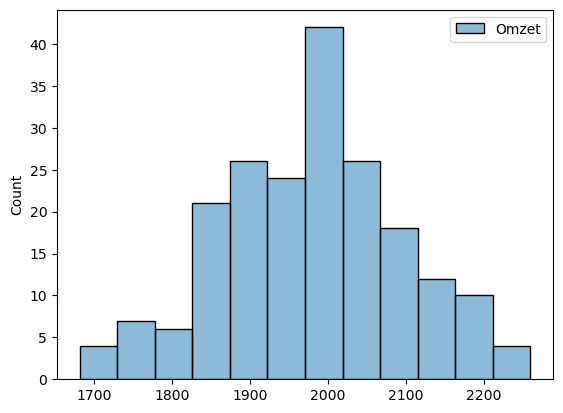

In [21]:
sns.histplot(verschil)

In [22]:
import numpy as np
import pandas as pd
from scipy import stats

# 1) Verschil als float en opschonen
verschil = pd.to_numeric(df3['Omzet'], errors='coerce') - pd.to_numeric(df1['Omzet'], errors='coerce')
x = verschil.to_numpy(dtype='float64')

# Drop NaN/inf
x = x[np.isfinite(x)]
n = x.size
sd = x.std(ddof=1) if n > 1 else np.nan

print(f"n={n}, mean={x.mean():.3f}" if n else "Geen data over na opschonen.")

results = {}

# 2) Shapiro–Wilk (3 <= n <= 5000)
if 3 <= n <= 5000:
    sw_stat, sw_p = stats.shapiro(x)
    results['Shapiro'] = (sw_stat, sw_p)

# 3) D’Agostino & Pearson K² (n >= 8)
if n >= 8:
    k2_stat, k2_p = stats.normaltest(x, nan_policy='omit')
    results["D'Agostino K²"] = (k2_stat, k2_p)

# 4) Anderson–Darling (altijd ok)
ad_res = stats.anderson(x, dist='norm')
results['Anderson'] = (ad_res.statistic, list(ad_res.critical_values), list(ad_res.significance_level))

# 5) KS op genormaliseerde data (alleen als sd>0)
if n >= 3 and np.isfinite(sd) and sd > 0:
    z = (x - x.mean()) / sd
    ks_stat, ks_p = stats.kstest(z, 'norm')
    results['KS (z~N(0,1))'] = (ks_stat, ks_p)

# 6) Netjes printen
for name, val in results.items():
    if name == 'Anderson':
        stat, crit, sig = val
        print(f"{name}: stat={stat:.3f}, critical={crit}, siglvl={sig}")
    else:
        stat, p = val
        print(f"{name}: stat={stat:.3f}, p={p:.4f}")

# (optioneel) snelle interpretatie:
def interpret_p(p): return "geen bewijs tégen normaliteit" if p >= 0.05 else "verwerp normaliteit"
if 'Shapiro' in results:
    print("Shapiro:", interpret_p(results['Shapiro'][1]))
if "D'Agostino K²" in results:
    print("D’Agostino:", interpret_p(results["D'Agostino K²"][1]))
if 'KS (z~N(0,1))' in results:
    print("KS:", interpret_p(results['KS (z~N(0,1))'][1]))


n=200, mean=1979.836
Shapiro: stat=0.992, p=0.3895
D'Agostino K²: stat=0.540, p=0.7633
Anderson: stat=0.348, critical=[0.565, 0.644, 0.772, 0.901, 1.071], siglvl=[15.0, 10.0, 5.0, 2.5, 1.0]
KS (z~N(0,1)): stat=0.043, p=0.8289
Shapiro: geen bewijs tégen normaliteit
D’Agostino: geen bewijs tégen normaliteit
KS: geen bewijs tégen normaliteit


In [23]:
# gemiddelde en standaardfout van verschil
mean_diff = np.mean(df3['Omzet']) - np.mean(df1['Omzet'])
se_diff   = np.sqrt(np.var(df3['Omzet'], ddof=1)/len(df3) +
                    np.var(df1['Omzet'], ddof=1)/len(df1))

# 95% CI van verschil
z = 1.96
ci_diff = (mean_diff - z*se_diff, mean_diff + z*se_diff)

# omzet naar dagen
ci_dagen = (120000/ci_diff[1], 120000/ci_diff[0])  # let op: omgekeerd delen!
print("95% CI dagen_b:", ci_dagen)


95% CI dagen_b: (60.09737974956768, 61.133646984142835)


In [24]:
verschil

0      1970.123205
1      1865.383069
2      2029.131320
3      2247.442166
4      1864.886017
          ...     
195    2055.515581
196    1905.114795
197    2228.048628
198    2047.341421
199    1983.610979
Name: Omzet, Length: 200, dtype: float64

> Slimmme dingen zeggen over CLT en normaal verdeling enzo + grafiekje behouden en uitleggen dat we daarom simpele manier de 95CI mogen berekenen